In [1]:
from IPython import display as disp
import torch
import torchaudio
from denoiser import pretrained
from denoiser.dsp import convert_audio
from scipy.signal import wiener, convolve
from scipy.special import sinc
import matplotlib.pyplot as plt
import numpy as np
import scipy
import matplotlib
import soundfile

In [2]:
torch.cuda.is_available()

True

In [115]:
import os
wav, sr = torchaudio.load("../audio/" + os.listdir("../audio")[3195], format="wav")
disp.display(disp.Audio(wav.numpy(), rate=sr))


In [116]:
nFFT = 1024
windowSize = nFFT
hopSize = 256
window = torch.hann_window(windowSize)

In [117]:
def melForward(f):
    return 2595*np.log10(1 + f/700) #wikipedia suggestion
def melInverse(m):
    return (10**(m/2595)-1)*700

C:\Users\maxro\AppData\Local\Temp\ipykernel_7036\3328093509.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


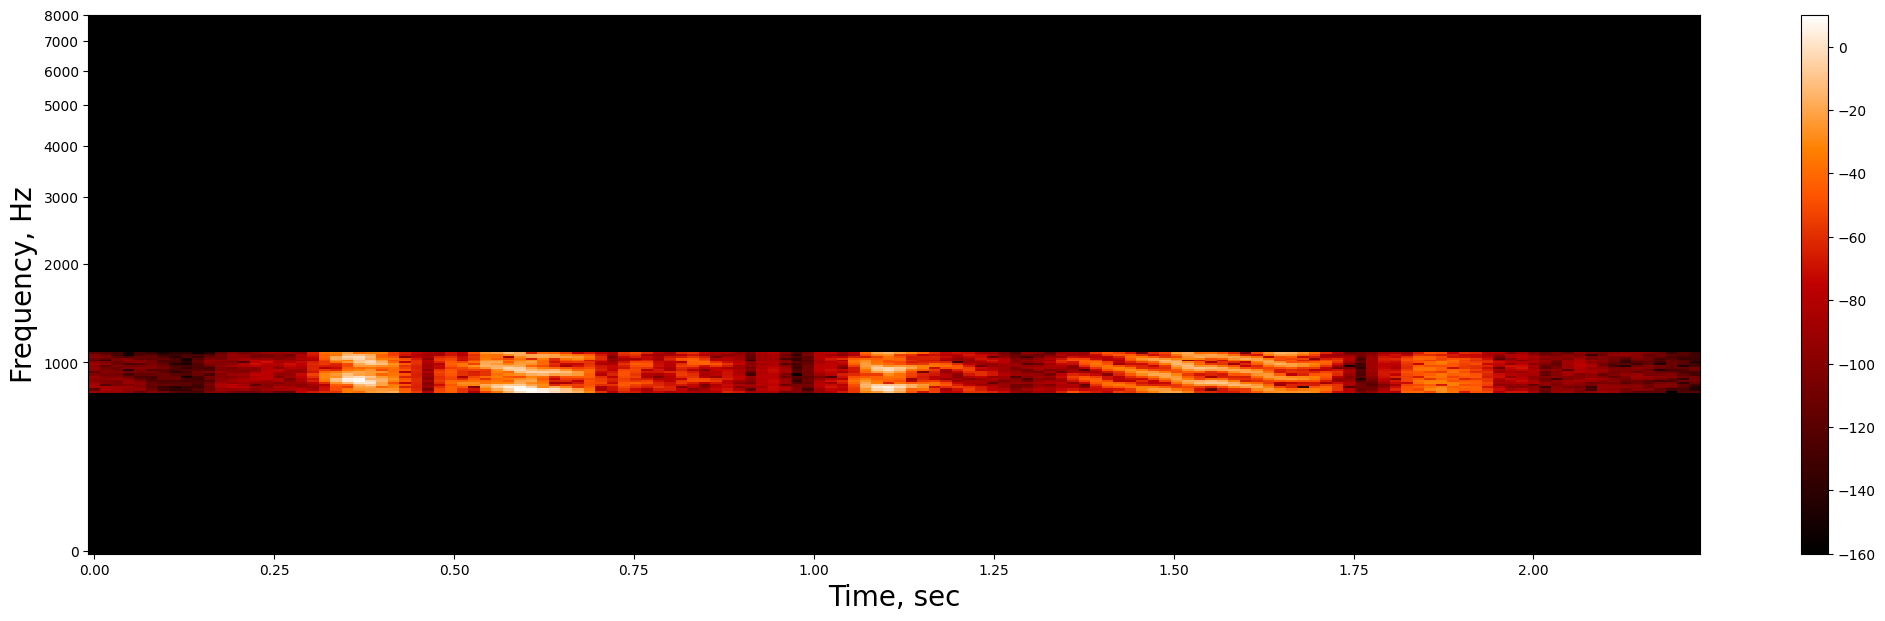

In [187]:
spectrum1 = torch.stft(
    wav,
    n_fft=nFFT,
    hop_length=hopSize,
    win_length=windowSize,
    window=window,
    center=False,
    onesided=True,
    return_complex=True,
)

# spectrogram = spectrum1.norm(dim=-1).pow(2)

spectrum1[:, :50] = 0
spectrum1[:, 70:] = 0

spectrogram = spectrum1.abs().pow(2)

f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,spectrogram.shape[2]*hopSize, hopSize)/sr
fGrid = np.arange(0,nFFT/2+0.00001)/(nFFT)*sr
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(spectrogram.squeeze()+1e-8),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

In [188]:
wav_revived = torch.istft(spectrum1,
    n_fft=nFFT,
    hop_length=hopSize,
    win_length=windowSize,
    window=window)

In [189]:
disp.display(disp.Audio(wav_revived.numpy(), rate=sr))

In [190]:
torch.cat((wav_revived, torch.zeros(wav.shape[1] - wav_revived.shape[1])[None, :]), dim=1).shape

torch.Size([1, 36640])

In [186]:
torch.norm(torch.cat((wav_revived, torch.zeros(wav.shape[1] - wav_revived.shape[1])[None, :]), dim=1)) / wav.shape[1]

tensor(0.0001)